<a href="https://colab.research.google.com/github/tabba98/neural-network/blob/main/nndl_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import time as time
import numpy as np
from IPython import display

!pip install open3d;
import open3d as o3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.5/422.5 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.5 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.7.1
    Uninstalling nbformat-5.7.1:
      Successfully uninstalled nbformat-5.7.1


In [2]:
!pip install path.py;
from path import Path

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2023-01-19 12:08:43--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.74
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2023-01-19 12:08:44--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  13.2MB/s    in 36s     

2023-01-19 12:09:21 (12.4 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [4]:
!unzip -q ModelNet10.zip;

In [ ]:
mesh = o3d.io.read_triangle_mesh('/content/ModelNet10/bed/train/bed_0001.off')
voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh,
                                                              voxel_size=0.05)
o3d.visualization.draw_geometries([voxel_grid])

In [ ]:
path = Path("ModelNet10")

In [ ]:
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

In [ ]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

In [ ]:
with open(path/"bed/train/bed_0001.off", 'r') as f:
  verts, faces = read_off(f)

In [ ]:
i,j,k = np.array(faces).T
x,y,z = np.array(verts).T

In [ ]:
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                    transition=dict(duration=0),
                                                                    fromcurrent=True,
                                                                    mode='immediate'
                                                                    )]
                                                    )
                                            ]
                                    )
                                ]
                    ),
                    frames=frames
            )

    return fig
     

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50, i=i,j=j,k=k)]).show()

In [ ]:
visualize_rotate([go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers')]).show()

In [ ]:
def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()

In [ ]:
pcshow(x,y,z)

In [ ]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points

In [ ]:
import random
pointcloud = PointSampler(3000)((verts, faces))


TypeError: ignored

In [ ]:
pcshow(*pointcloud.T)

In [ ]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [ ]:
norm_pointcloud = Normalize()(pointcloud)

In [ ]:
pcshow(*norm_pointcloud.T)

In [ ]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud
     

In [ ]:
import math
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)
     

In [ ]:
pcshow(*noisy_rot_pointcloud.T)

In [ ]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [ ]:
ToTensor()(noisy_rot_pointcloud)

In [ ]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

In [ ]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])
     

In [ ]:
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

In [ ]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

In [ ]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64
     

In [ ]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


In [ ]:
pointnet = PointNet()
pointnet.to(device);

In [ ]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [ ]:
def train(model, train_loader, val_loader=None,  epochs=5, save=True):
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        if save:
            torch.save(pointnet.state_dict(), "save_" + str(epoch) + ".pth")

In [ ]:
train(pointnet, train_loader, valid_loader, save=True)

In [ ]:
from sklearn.metrics import confusion_matrix
     

In [ ]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load('save.pth'))
pointnet.eval();

In [ ]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

In [ ]:
cm = confusion_matrix(all_labels, all_preds);
cm

In [ ]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 9.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import Accuracy
from torchmetrics import ConfusionMatrix



#for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

import scipy
from scipy.ndimage import rotate

import time

In [ ]:
%%capture
!wget https://www.dropbox.com/s/ja56cvf3x4mkf1t/modelnet10_voxelized_32.npz                   

%%capture
!wget https://www.dropbox.com/s/sfs9kd33qnvo7n0/modelnet10_voxelized_64.npz

In [ ]:
class VoxelDataset(Dataset):
    def __init__(self, train = True, size=32):
        if size == 32:
            if train:
                tmp = np.load("modelnet10_voxelized_32.npz")
                self.data = tmp["X_train"]
                self.label = tmp["Y_train"]
                del tmp
            else:
                tmp = np.load("modelnet10_voxelized_32.npz")
                self.data = tmp["X_test"]
                self.label = tmp["Y_test"]
                del tmp
        else:
            if train:
                tmp = np.load("modelnet10_voxelized_64.npz")
                self.data = tmp["X_train"]
                self.label = tmp["Y_train"]
                del tmp
            else:
                tmp = np.load("modelnet10_voxelized_64.npz")
                self.data = tmp["X_test"]
                self.label = tmp["Y_test"]
                del tmp
                
    def __len__(self):
        return len(self.label)

    def __preproc__(self, voxels):
        
        #flip x
        if np.random.randint(2):
            voxels = np.flip(voxels, axis=0)
        
        #flip y
        if np.random.randint(2):
            voxels = np.flip(voxels, axis=1)
        
        angle = 360 * np.random.random_sample(1)[0]
        
        voxels = rotate(voxels, axes=(0, 1), angle=angle, cval=0.0, reshape=False)
        
        
        return voxels.copy()

    def __getitem__(self, idx):
        label = self.label[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label

In [ ]:
class VoxelNet(nn.Module):
    def __init__(self, model_parameters, n_classes=10, data_size=32):
        super().__init__()
        self.n_classes = n_classes
        self.data_size = data_size
        self.model_parameters = model_parameters
        
        #features
        self.conv3d_1 = nn.Conv3d(in_channels=1, out_channels=model_parameters["features1"], kernel_size=5, stride=2)
        self.dropout1 = nn.Dropout(p=model_parameters["dropout"])
        self.conv3d_2 = nn.Conv3d(in_channels=model_parameters["features1"], out_channels=model_parameters["features2"], kernel_size=3)
        self.dropout2 = nn.Dropout(p=model_parameters["dropout"])
        self.maxpool = nn.MaxPool3d(2)
        
        
        
        if data_size==64:
            dim=351232
            351232
        else:
            dim=27648
            
        #calculate dim after pooling for fc layer
        x = torch.rand((1,1,data_size,data_size,data_size))
        x = F.relu(self.conv3d_1(x))
        x = self.dropout1(x)
        x = F.relu(self.conv3d_2(x))
        x = self.dropout2(x)
        x = self.maxpool(x)
        dim = x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3] * x.shape[4]
        
        #mlp
        self.fc1 = nn.Linear(dim, model_parameters["fc1"])
        self.dropout3 = nn.Dropout(p=model_parameters["dropout"])
        self.fc2 = nn.Linear(model_parameters["fc1"], self.n_classes)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
        #features
        x = F.relu(self.conv3d_1(x))
        x = self.dropout1(x)
        x = F.relu(self.conv3d_2(x))
        x = self.dropout2(x)
        
        #maxpool
        x = self.maxpool(x)
        
        #flatten
        x = x.view(x.size(0), -1)
        
        #mlp
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        
        return self.logsoftmax(x)

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
        smoothed_val = w * last + (1 - w) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
        
    return smoothed

In [ ]:
class VoxNet_Trainer():
    def __init__(self, hyperparameters, model_hyperparameters):
        
        #Hypreparameters
        self.learning_rate = hyperparameters["learning_rate"]
        self.batch_size_train = hyperparameters["train_batch_size"]
        self.batch_size_test = hyperparameters["valid_batch_size"]
        self.data_size = hyperparameters["data_size"]
        self.sgd_momentum = hyperparameters["sgd_momentum"]
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.epochs = hyperparameters["epochs"]
        self.model_hyperparameters = model_hyperparameters
        
        #Logging
        self.print_epoch_rate = hyperparameters["print_epoch_rate"]
        self.verbose = hyperparameters["verbose"]
        
        if self.verbose:
            print("loading dataset...\n")
            
        #Dataset
        self.initDataset()
        self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
        self.num_classes = len(self.class_names)
        
        if self.verbose:
            print("loading model...\n")
            
        #Model
        self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
        self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
        self.initModel()
        
    def initDataset(self):
        self.train_ds = VoxelDataset(train=True, size=self.data_size)
        self.test_ds = VoxelDataset(train=False, size=self.data_size)
        self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
        self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)
    
    def initModel(self):
        self.model = VoxelNet(model_parameters=self.model_hyperparameters, data_size=self.data_size)
        self.model.to(self.device)
        #self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
        self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)
        self.loss_func = nn.NLLLoss()
    
    def numberOfParameters(self):
        return  sum(p.numel() for p in self.model.parameters())
    
    def train(self):
        train_loss_history, valid_loss_history = [], []
        train_acc_history, valid_acc_history = [], []

        train_accuracy = Accuracy(task='multiclass', num_classes=10)
        valid_accuracy = Accuracy(task='multiclass', num_classes=10)

        
        if self.verbose:
            print("started training...\n")
                       
        total_time = time.time()
        for epoch in range(0, self.epochs):            
            t = time.time()
            
            train_loss = []                                                         #track training loss
            valid_loss = []                                                         #track valid loss
            
            #track loss for 10 batch
            batch_loss=0
            
            #training on batches
            self.model.train()
            for i, data in enumerate(self.train_dataloader, 0):
                x, y = data[0].to(self.device), data[1].to(self.device)              #send to device
                self.optimizer.zero_grad()
                pred = self.model(x)                                     #predict class
                loss = self.loss_func(pred, y)          #compute and track loss
                train_loss.append(loss.cpu().data)                                   #track loss
                acc = train_accuracy(torch.argmax(pred, 1).cpu(), y.cpu())           #track accuracy
                
                #back propagate and optimize
                loss.backward()
                self.optimizer.step()
                self.lr_scheduler.step()
                
            pred_conf = []                                                           #track for confusion matrix
            y_conf = []                                                              #track for confusion matrix
            
            
            #validation on batches
            self.model.eval()
            for x, y in self.test_dataloader:
                x, y = x.to(self.device), y.to(self.device)                           #send to device
                pred = self.model(x)                                      #predict class
                loss = self.loss_func(pred, y)           #compute and track loss
                valid_loss.append(loss.cpu().data)                                    #track loss
                valid_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())           #track accuracy
                pred_conf.append(torch.argmax(pred, 1))
                y_conf.append(y)
                
            #compute confusion matrix
            a = torch.cat(pred_conf).cpu()
            b = torch.cat(y_conf).cpu()
            confmat = ConfusionMatrix(task='multiclass', num_classes=self.num_classes, normalize="true")
            self.conf_matrix = confmat(a, b)
            self.conf_matrix = torch.round(self.conf_matrix, decimals=2)
            
            # total accuracy over all batches
            total_train_accuracy = train_accuracy.compute()
            total_valid_accuracy = valid_accuracy.compute()
            train_accuracy.reset()
            valid_accuracy.reset()
            
            #track loss and acc for plotting
            train_loss_history.append(torch.mean(torch.tensor(train_loss)))
            valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
            train_acc_history.append(total_train_accuracy)
            valid_acc_history.append(total_valid_accuracy)
            
            elapsed_time_epoch = time.time() - t   
            
            if epoch % self.print_epoch_rate == 0 and self.verbose:
                tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
                tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
                tmp2 = "train-loss: {:4.2f}, train-acc: {:.2%}".format(train_loss_history[epoch], train_acc_history[epoch].item())
                tmp3 = "valid-loss: {:4.2f}, valid-acc: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history[epoch].item())
                print(tmp0, tmp1, tmp2, tmp3, sep="\n")
            
            
            
        #save history
        self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history), "valid_loss": torch.tensor(valid_loss_history), "valid_acc": torch.tensor(valid_acc_history)}
        
        
        elapsed_time_training = time.time() - total_time
        #print end results
        if self.verbose:
            idc = torch.argmax(torch.tensor(valid_acc_history)).item()
            print("\nfinished training:\n")
            print("time: {:.2f} seconds".format(elapsed_time_training))
            print("time: {:.2f} minutes".format(elapsed_time_training/60))
            print("accuracy: {:.2%}".format(valid_acc_history[idc].item()))
            print("loss: {:4.2f}".format(valid_loss_history[idc]))
        
        
    #TODO  
    def saveModel(self, path = "/kaggle/working/model.pth"):
        self.path = path
        torch.save(self.model.state_dict(), path)
    
    def getClasses(self):
        return {i: c for i, c in enumerate(self.class_names, 0)}
    
    def generateConfusionMatrix(self):
        fig=plt.figure(figsize = (12,7))
        sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
        tick_marks = np.arange(len(self.class_names))
        plt.xticks(tick_marks, self.class_names, rotation=45)
        plt.yticks(tick_marks, self.class_names, rotation=0)
        plt.title("Confusion Matrix")

    
    def getPerClassAccuracy(self):
        per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
        tmp = {}
        for i, x in enumerate(self.class_names):
            tmp[x] = per_class_accuracy[i].item()
        
    # figure to subfigure
    def showResults(self):
        eps = range(0, len(self.history["train_loss"].cpu()))
        
        sns.set_theme()
        fig, ax = plt.subplots(1, 2, figsize=(14, 4))
        fig.suptitle('Results')
        
        ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
        ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
        ax[0].set_title('Loss History')
        ax[0].set(xlabel='Epochs', ylabel='Loss')
        ax[0].legend()
        
        ax[1].plot(eps, smooth(self.history["train_acc"].cpu()), 'g', label='Training Accuracy')
        ax[1].plot(eps, smooth(self.history["valid_acc"].cpu()), 'b', label='Valid Accuracy')
        ax[1].set_title('Loss History')
        ax[1].set(xlabel='Epochs', ylabel='Accuracy')
        ax[1].legend()
        
        
    def draw_voxels(self):
        mesh = next(iter(self.train_dataloader))
        mesh = mesh[0][0][0]
        
        ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
        ax.voxels(mesh, edgecolor='k')
        plt.show()
    
    def test_on_missing_data(self, missing_rate=0.5):
        test_accuracy = Accuracy(task='multiclass', num_classes=10)
        
        self.model.eval()
        for x, y in self.test_dataloader:
            x, y = x.to(self.device), y.to(self.device)
            
            idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
            idc_x = idc%32
            idc_y = np.floor_divide(idc, 32)%32
            idc_z = np.floor_divide(idc, 32*32)%32
            x[:, :, idc_x, idc_y, idc_z] = 0
            
            pred = self.model(x)
            test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
        return test_accuracy.compute()
    
    def missing_data_test(self):
        acc = []
        delta = 200
        eps = np.linspace(0,0.99,delta)
        for x in eps:
            tmp = self.test_on_missing_data(x)
            acc.append(tmp)
            
            
        sns.set_theme()
        plt.figure(figsize=(8, 4))
        plt.plot(eps, smooth(acc))
        plt.title("Missing Data Test", size=20, y=1.05)
        plt.xlabel("missing point ratio", size=15)
        plt.ylabel("accuracy", size=15)
        plt.show()

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.1,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 15,
    "train_batch_size": 128,
    "valid_batch_size": 128,
    "lr_scheduler_step": 20,
    "lr_scheduler_gamma": 0.5,
    "print_epoch_rate": 1,
    "verbose":1
}        

model_hyperparameters = {
    "dropout": 0.4,
    "features1": 32,
    "features2": 32,
    "fc1": 128
}

trainer = VoxNet_Trainer(training_hyperparameters, model_hyperparameters)
print("numberOfParameters\n", trainer.numberOfParameters())
trainer.train()

loading dataset...

loading model...

numberOfParameters
 917866
started training...

epoch:  1 / 15
time: 31.63 seconds
train-loss: 1.90, train-acc: 34.75%
valid-loss: 1.37, valid-acc: 51.76%

epoch:  2 / 15
time: 25.93 seconds
train-loss: 1.03, train-acc: 66.96%
valid-loss: 0.93, valid-acc: 69.38%

epoch:  3 / 15
time: 24.47 seconds
train-loss: 0.72, train-acc: 76.26%
valid-loss: 0.75, valid-acc: 73.79%

epoch:  4 / 15
time: 24.51 seconds
train-loss: 0.62, train-acc: 80.37%
valid-loss: 0.71, valid-acc: 74.67%

epoch:  5 / 15
time: 33.53 seconds
train-loss: 0.58, train-acc: 81.63%
valid-loss: 0.69, valid-acc: 76.21%

epoch:  6 / 15
time: 25.70 seconds
train-loss: 0.57, train-acc: 82.21%
valid-loss: 0.69, valid-acc: 75.77%

epoch:  7 / 15
time: 24.67 seconds
train-loss: 0.56, train-acc: 83.42%
valid-loss: 0.69, valid-acc: 76.43%

epoch:  8 / 15
time: 24.82 seconds
train-loss: 0.56, train-acc: 83.22%
valid-loss: 0.70, valid-acc: 75.77%

epoch:  9 / 15
time: 24.80 seconds
train-loss: 0.5

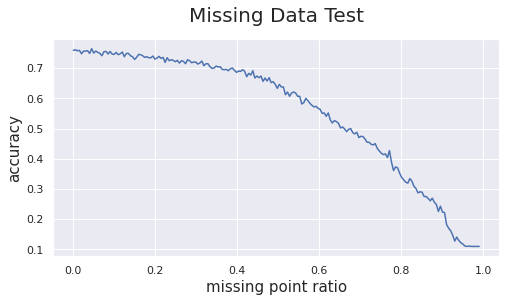

In [ ]:
trainer.missing_data_test()

FileNotFoundError: ignored

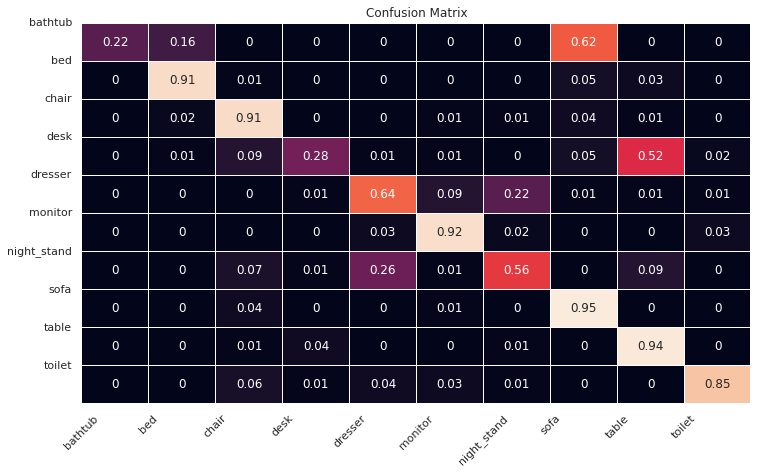

In [ ]:
trainer.generateConfusionMatrix()

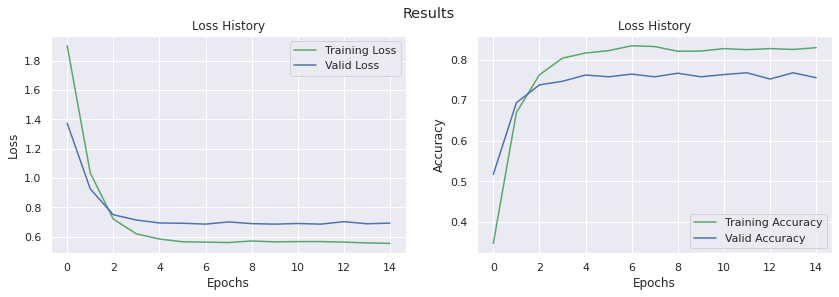

In [ ]:
trainer.showResults()

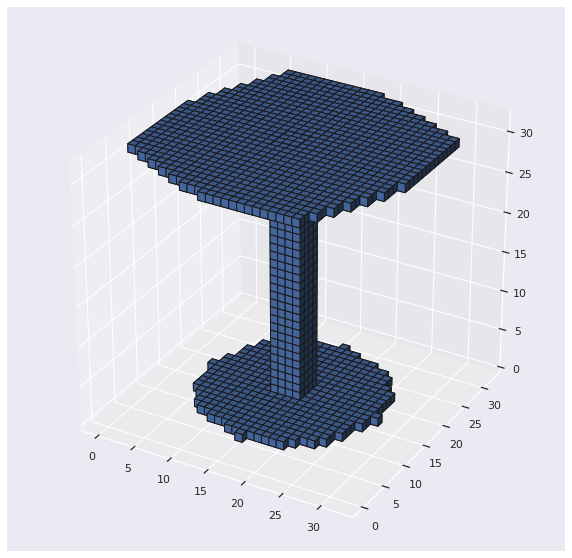

In [ ]:
trainer.draw_voxels()

In [ ]:
import os

import numpy as np

class Voxels(object):
    """ Holds a binvox model.
    data is either a three-dimensional numpy boolean array (dense representation)
    or a two-dimensional numpy float array (coordinate representation).
    dims, translate and scale are the model metadata.
    dims are the voxel dimensions, e.g. [32, 32, 32] for a 32x32x32 model.
    scale and translate relate the voxels to the original model coordinates.
    To translate voxel coordinates i, j, k to original coordinates x, y, z:
    x_n = (i+.5)/dims[0]
    y_n = (j+.5)/dims[1]
    z_n = (k+.5)/dims[2]
    x = scale*x_n + translate[0]
    y = scale*y_n + translate[1]
    z = scale*z_n + translate[2]
    """

    def __init__(self, data, dims, translate, scale, axis_order):
        self.data = data
        self.dims = dims
        self.translate = translate
        self.scale = scale
        assert (axis_order in ('xzy', 'xyz'))
        self.axis_order = axis_order

    def clone(self):
        data = self.data.copy()
        dims = self.dims[:]
        translate = self.translate[:]
        return Voxels(data, dims, translate, self.scale, self.axis_order)

    def write(self, fp):
        write(self, fp)

def read_header(fp):
    """ Read binvox header. Mostly meant for internal use.
    """
    line = fp.readline().strip()
    if not line.startswith(b'#binvox'):
        raise IOError('Not a binvox file')
    dims = list(map(int, fp.readline().strip().split(b' ')[1:]))
    translate = list(map(float, fp.readline().strip().split(b' ')[1:]))
    scale = list(map(float, fp.readline().strip().split(b' ')[1:]))[0]
    line = fp.readline()
    return dims, translate, scale

def read_as_3d_array(fp, fix_coords=True):
    """ Read binary binvox format as array.
    Returns the model with accompanying metadata.
    Voxels are stored in a three-dimensional numpy array, which is simple and
    direct, but may use a lot of memory for large models. (Storage requirements
    are 8*(d^3) bytes, where d is the dimensions of the binvox model. Numpy
    boolean arrays use a byte per element).
    Doesn't do any checks on input except for the '#binvox' line.
    """
    dims, translate, scale = read_header(fp)
    raw_data = np.frombuffer(fp.read(), dtype=np.uint8)
    # if just using reshape() on the raw data:
    # indexing the array as array[i,j,k], the indices map into the
    # coords as:
    # i -> x
    # j -> z
    # k -> y
    # if fix_coords is true, then data is rearranged so that
    # mapping is
    # i -> x
    # j -> y
    # k -> z
    values, counts = raw_data[::2], raw_data[1::2]
    data = np.repeat(values, counts).astype(np.bool)
    data = data.reshape(dims)
    if fix_coords:
        # xzy to xyz TODO the right thing
        data = np.transpose(data, (0, 2, 1))
        axis_order = 'xyz'
    else:
        axis_order = 'xzy'
    return Voxels(data, dims, translate, scale, axis_order)

def read_as_coord_array(fp, fix_coords=True):
    """ Read binary binvox format as coordinates.
    Returns binvox model with voxels in a "coordinate" representation, i.e.  an
    3 x N array where N is the number of nonzero voxels. Each column
    corresponds to a nonzero voxel and the 3 rows are the (x, z, y) coordinates
    of the voxel.  (The odd ordering is due to the way binvox format lays out
    data).  Note that coordinates refer to the binvox voxels, without any
    scaling or translation.
    Use this to save memory if your model is very sparse (mostly empty).
    Doesn't do any checks on input except for the '#binvox' line.
    """
    dims, translate, scale = read_header(fp)
    raw_data = np.frombuffer(fp.read(), dtype=np.uint8)

    values, counts = raw_data[::2], raw_data[1::2]

    sz = np.prod(dims)
    index, end_index = 0, 0
    end_indices = np.cumsum(counts)
    indices = np.concatenate(([0], end_indices[:-1])).astype(end_indices.dtype)

    values = values.astype(np.bool)
    indices = indices[values]
    end_indices = end_indices[values]

    nz_voxels = []
    for index, end_index in zip(indices, end_indices):
        nz_voxels.extend(range(index, end_index))
    nz_voxels = np.array(nz_voxels)
    # TODO are these dims correct?
    # according to docs,
    # index = x * wxh + z * width + y; // wxh = width * height = d * d

    x = nz_voxels / (dims[0]*dims[1])
    zwpy = nz_voxels % (dims[0]*dims[1]) # z*w + y
    z = zwpy / dims[0]
    y = zwpy % dims[0]
    if fix_coords:
        data = np.vstack((x, y, z))
        axis_order = 'xyz'
    else:
        data = np.vstack((x, z, y))
        axis_order = 'xzy'

    #return Voxels(data, dims, translate, scale, axis_order)
    return Voxels(np.ascontiguousarray(data), dims, translate, scale, axis_order)

def dense_to_sparse(voxel_data, dtype=np.int):
    """ From dense representation to sparse (coordinate) representation.
    No coordinate reordering.
    """
    if voxel_data.ndim!=3:
        raise ValueError('voxel_data is wrong shape; should be 3D array.')
    return np.asarray(np.nonzero(voxel_data), dtype)

def sparse_to_dense(voxel_data, dims, dtype=np.bool):
    if voxel_data.ndim!=2 or voxel_data.shape[0]!=3:
        raise ValueError('voxel_data is wrong shape; should be 3xN array.')
    if np.isscalar(dims):
        dims = [dims]*3
    dims = np.atleast_2d(dims).T
    # truncate to integers
    xyz = voxel_data.astype(np.int)
    # discard voxels that fall outside dims
    valid_ix = ~np.any((xyz < 0) | (xyz >= dims), 0)
    xyz = xyz[:,valid_ix]
    out = np.zeros(dims.flatten(), dtype=dtype)
    out[tuple(xyz)] = True
    return out

#def get_linear_index(x, y, z, dims):
    #""" Assuming xzy order. (y increasing fastest.
    #TODO ensure this is right when dims are not all same
    #"""
    #return x*(dims[1]*dims[2]) + z*dims[1] + y

def write(voxel_model, fp):
    """ Write binary binvox format.
    Note that when saving a model in sparse (coordinate) format, it is first
    converted to dense format.
    Doesn't check if the model is 'sane'.
    """
    if voxel_model.data.ndim==2:
        # TODO avoid conversion to dense
        dense_voxel_data = sparse_to_dense(voxel_model.data, voxel_model.dims)
    else:
        dense_voxel_data = voxel_model.data

    fp.write('#binvox 1\n')
    fp.write('dim '+' '.join(map(str, voxel_model.dims))+'\n')
    fp.write('translate '+' '.join(map(str, voxel_model.translate))+'\n')
    fp.write('scale '+str(voxel_model.scale)+'\n')
    fp.write('data\n')
    if not voxel_model.axis_order in ('xzy', 'xyz'):
        raise ValueError('Unsupported voxel model axis order')

    if voxel_model.axis_order=='xzy':
        voxels_flat = dense_voxel_data.flatten()
    elif voxel_model.axis_order=='xyz':
        voxels_flat = np.transpose(dense_voxel_data, (0, 2, 1)).flatten()

    # keep a sort of state machine for writing run length encoding
    state = voxels_flat[0]
    ctr = 0
    for c in voxels_flat:
        if c==state:
            ctr += 1
            # if ctr hits max, dump
            if ctr==255:
                fp.write(chr(state))
                fp.write(chr(ctr))
                ctr = 0
        else:
            # if switch state, dump
            fp.write(chr(state))
            fp.write(chr(ctr))
            state = c
            ctr = 1
    # flush out remainders
    if ctr > 0:
        fp.write(chr(state))
        fp.write(chr(ctr))

ROOT = '/content/ModelNet10/'
CLASSES = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']

X = {'train': [], 'test': []}
y = {'train': [], 'test': []}
for label, cl in enumerate(CLASSES):
    for split in ['train', 'test']:
        examples_dir = os.path.join(ROOT, cl, split)
        for example in os.listdir(examples_dir):
            if 'binvox' in example:
                with open(os.path.join(examples_dir, example), 'rb') as file:
                    data = np.int32(read_as_3d_array(file).data)
                    padded_data = np.pad(data, 3, 'constant')
                    X[split].append(padded_data)
                    y[split].append(label)

np.savez_compressed('modelnet10.npz',
                    X_train=X['train'],
                    X_test=X['test'],
                    y_train=y['train'],
                    y_test=y['test'])

<ipython-input-69-4d50dafcce16>:130: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<ipython-input-69-4d50dafcce16>:138: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

